In [1]:
import pickle as pkl    
import os
from pcdet.ops.iou3d_nms import iou3d_nms_utils
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import torch
os.chdir('/home/cgriesbacher/thesis/3DTrans/')

### Init functions

In [2]:
def calc_ious(pseudo_labels, gt_labels):
    #add iou score to the dataframe, default is 0
    pseudo_labels['iou'] = 0
    pseudo_labels['true_label'] = "Background"
    gt_labels['iou'] = 0

    #det detection frame ids
    ps_frame_ids = pseudo_labels['frame_id'].unique()

    # Loop over all frames
    for ps_frame_id in tqdm.tqdm(ps_frame_ids):

        gt_labels_frame = gt_labels[gt_labels['frame_id'] == ps_frame_id]
        pseudo_labels_frame = pseudo_labels[pseudo_labels['frame_id'] == ps_frame_id]

        if len(gt_labels_frame) == 0 or len(pseudo_labels_frame) == 0:
            print(f"Frame {ps_frame_id} has no gts or no detections")
            continue

        # Convert the boxes to numpy
        gt_boxes_frame = np.stack(gt_labels_frame["gt_boxes_lidar"].values)
        ps_boxes_frame = np.stack(pseudo_labels_frame["boxes_lidar"].values)

        #iou_matrix = iou3d_nms_utils.boxes_iou3d_gpu(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        iou_matrix = iou3d_nms_utils.boxes_iou_bev(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        #iou_matrix = iou3d_nms_utils.boxes_bev_iou_cpu(gt_boxes_frame, ps_boxes_frame)
        
        # Get the max iou for each det box
        max_ious_ps = np.max(iou_matrix, axis=0)
        max_ious_ps_idx = np.argmax(iou_matrix, axis=0)

        # get class for each detection
        cls_dets = gt_labels_frame['names'].values[max_ious_ps_idx]
        
        # Update the iou score for each detection in the original DataFrame
        pseudo_labels.loc[pseudo_labels_frame.index, 'iou'] = max_ious_ps
        pseudo_labels.loc[pseudo_labels_frame.index, 'true_label'] = cls_dets
        # print(f"Percentage of detection ious greater than 0: {round(len(max_ious_ps[max_ious_ps > 0])/len(max_ious_ps),2)}")

        # Get max_iou for each gt box
        max_ious_gts = np.max(iou_matrix, axis=1)

        # Update the iou score for each gt in the original DataFrame
        gt_labels.loc[gt_labels_frame.index, 'iou'] = max_ious_gts
        #percentage of ious that are greater than 0
        # print(f"Percentage of gt ious greater than 0: {round(len(max_ious_gts[max_ious_gts > 0])/len(max_ious_gts),2)}")

        # XXX: only update if score is higher than current score


    iou_thresholds = [0.1, 0.3, 0.5, 0.7]

    #for each detection, add detected_0.3, detected_0.5, detected_0.7
    for iou_threshold in iou_thresholds:
        pseudo_labels[f'detected_{iou_threshold}'] = pseudo_labels['iou'] >= iou_threshold
        gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold

    return pseudo_labels, gt_labels

def load_detections(path, df):
    with open(path, 'rb') as f:
        dets = pkl.load(f)

    #make a dataframe
    df_dets_dataset = pd.DataFrame(dets)
    
    #get datasset name from path
    eval_dataset = path.split('/')[-2]
    train_dataset = path.split('/')[-8].split('_')[0]


    #add a column with the dataset name
    df_dets_dataset['eval_dataset'] = eval_dataset
    df_dets_dataset['train_dataset'] = train_dataset

    cols_to_explode = ['name', 'score', 'boxes_lidar', 'pred_labels', 'train_dataset', 'eval_dataset', 'frame_id']
    exploded_list = [df_dets_dataset[col].explode() for col in cols_to_explode]
    exploded_df = pd.concat(exploded_list, axis=1)

    # Adding non-exploded columns
    for col in df_dets_dataset.columns:
        if col not in cols_to_explode:
            exploded_df[col] = df[col].values[0]

    # Reset index if needed
    df_det_expl = exploded_df.reset_index(drop=True)

    df_det_expl = df_det_expl.dropna()

    df_new = pd.concat([df, df_det_expl], axis=0)
    df_new = df_new.reset_index(drop=True)

    print("loaded {} detections on dataset {} with model trained on {}".format(len(df_det_expl), eval_dataset, train_dataset))

    return df_new.copy()


def load_gt_labels(split):

    assert split in ['train', 'val']
    dataset_names = ["avltruck", "avlrooftop", "zod"]

    #annotation paths
    annotation_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_infos_"+split+".pkl"
    annotation_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/data/avlrooftop/avl_infos_"+split+".pkl"
    annotation_path_zod = "/home/cgriesbacher/thesis/3DTrans/data/zod/zod_infos_"+split+"_full.pkl"

    #load the annotations and make a dataframe
    with open(annotation_path_avltruck, 'rb') as f:
        annotations_avltruck = pkl.load(f)
    with open(annotation_path_avlrooftop, 'rb') as f:
        annotations_avlrooftop = pkl.load(f)
    with open(annotation_path_zod, 'rb') as f:
        annotations_zod = pkl.load(f)

    avltruck_content = []
    for i in range(len(annotations_avltruck)):
        content = {}
        content["names"] = annotations_avltruck[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avltruck[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[0]
        content['frame_id'] = annotations_avltruck[i]["point_cloud"]['lidar_idx']
        avltruck_content.append(content)

    avlrooftop_content = []
    for i in range(len(annotations_avlrooftop)):
        content = {}
        content["names"] = annotations_avlrooftop[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avlrooftop[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[1]
        content['frame_id'] = annotations_avlrooftop[i]["point_cloud"]['lidar_idx']
        avlrooftop_content.append(content)

    zod_content = []
    for i in range(len(annotations_zod)):
        content = {}
        content["names"] = annotations_zod[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_zod[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[2]
        content['frame_id'] = annotations_zod[i]["point_cloud"]['lidar_idx']
        zod_content.append(content)

    #make a dataframe
    df_avltruck_annos = pd.DataFrame(avltruck_content)
    df_avlrooftop_annos = pd.DataFrame(avlrooftop_content)
    df_zod_annos = pd.DataFrame(zod_content)

    #make a dataframe with all results
    df_annos_full = pd.concat([df_avltruck_annos, df_avlrooftop_annos, df_zod_annos], axis=0) 
    df_annos_full = df_annos_full.reset_index(drop=True)

    #explode the lists
    cols_to_explode = ['names', 'gt_boxes_lidar', 'dataset', 'frame_id']
    df_annos_lists = [df_annos_full[col].explode() for col in cols_to_explode]
    df_annos_full = pd.concat(df_annos_lists, axis=1)

    prev_len = len(df_annos_full)
    df_annos_full.dropna(inplace=True)
    print(f"Dropped {prev_len - len(df_annos_full)} rows with NaNs")


    namemap_avltruck = {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Truck": "Truck",
        "Trailer": "Truck",
        "Dont_Care": "DontCare",
        "Other": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_avlrooftop =  {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "LargeVehicle_Truck": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_Bus_Bendy": "Truck",
        "Trailer": "Truck",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "PPObject": "DontCare",
        "PPObject_Stroller": "DontCare",
        "Dont_care": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_zod = {
        "Vehicle_Car": "Vehicle",
        "Vehicle_Van": "Vehicle",
        "Vehicle_Truck": "Truck",
        "Vehicle_Trailer": "Truck",
        "Vehicle_Bus": "Truck",
        "Vehicle_HeavyEquip": "Truck",
        "Vehicle_TramTrain": "Truck",
        "VulnerableVehicle_Motorcycle": "Cyclist",
        "VulnerableVehicle_Bicycle": "Cyclist",
        "Pedestrian": "Pedestrian",
        #'Placeholder': 'DontCare',
    }

    #apply name maps for all data of each dataset
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avltruck[x] if x in namemap_avltruck.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avlrooftop[x] if x in namemap_avlrooftop.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_zod[x] if x in namemap_zod.keys() else x)

    #drop all dont cares
    df_annos_full = df_annos_full[df_annos_full['names'] != 'DontCare']

    return df_annos_full

def plot_confusion_matrix(pseudo_labels, gt_labels, iou_threshold, epochs, pseudo_labels_folder_path=None, show_plot=True, do_print=False):
    if do_print:
        #print number of detections
        print(f"Number of detections: {len(pseudo_labels)}")
        #num dets per frame
        print(f"Number of detections per frame: {round(len(pseudo_labels)/len(pseudo_labels['frame_id'].unique()),2)}")

        #num gt
        print(f"Number of gt: {len(gt_labels)}")
        #num gt per frame
        print(f"Number of gt per frame: {round(len(gt_labels)/len(gt_labels['frame_id'].unique()),2)}")

        print()


    #detected as _ true label
    pseudo_labels_vehicles = pseudo_labels[pseudo_labels['name'] == 'Vehicle']
    vehicles_vehicle = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Vehicle')])
    vehicles_other = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Other')])
    vehicles_background = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_other = pseudo_labels[pseudo_labels['name'] == 'Other']
    other_vehicle = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Vehicle')])
    other_other = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Other')])
    other_background = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_unsure = pseudo_labels[pseudo_labels['name'] == 'Unsure']
    unsure_vehicle = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Vehicle')]) 
    unsure_other = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Other')])
    unsure_background = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == False)])

    background_vehicle = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['names'] == 'Vehicle')])
    background_other = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['names'] == 'Other')])

    if do_print:
        print("Detected as vehicle, true label vehicle: ", vehicles_vehicle)
        print("Detected as vehicle, true label other: ", vehicles_other)
        print("Detected as vehicle, true label background: ", vehicles_background)
        print()
        print("Detected as other, true label vehicle: ", other_vehicle)
        print("Detected as other, true label other: ", other_other)
        print("Detected as other, true label background: ", other_background)
        print()
        print("Detected as unsure, true label vehicle: ", unsure_vehicle)
        print("Detected as unsure, true label other: ", unsure_other)
        print("Detected as unsure, true label background: ", unsure_background)

#    confusion_matrix = [[0, vehicles_background, other_background, unsure_background],
#                        [background_vehicle, vehicles_vehicle, other_vehicle, unsure_vehicle],
#                        [background_other, vehicles_other, other_other, unsure_other],
#                        [0, 0, 0, 0]]
    
    confusion_matrix = [[0, vehicles_background, unsure_background],
                        [background_vehicle, vehicles_vehicle, unsure_vehicle],
                        [0, 0, 0]]
    confusion_matrix = np.array(confusion_matrix)

    plt.figure(figsize=(10, 5))
    plt.title('Confusion matrix epoch'+str(epochs)+' iou'+str(iou_threshold))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.xticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.yticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.yticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.ylabel('True label')
    plt.xlabel('Pseudo label')

    if pseudo_labels_folder_path is not None:
        #save image to path pseudo_labels_folder_path
        plt.savefig(os.path.join(pseudo_labels_folder_path, f"confusion_matrix_e{epochs}_iou{iou_threshold}.png"), dpi=300)

    if show_plot:
        plt.show()

### Load gt labels

In [15]:
split = "val"
gt_labels_all = load_gt_labels(split)
gt_labels_all["dataset"].value_counts()

Dropped 341 rows with NaNs


zod           147897
avltruck      137154
avlrooftop     25172
Name: dataset, dtype: int64

### Load detections

In [6]:
#init empty dataframe
detections_all = pd.DataFrame()

#results_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/avltruck/result.pkl"
results_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/zod_models/pvrcnnpp_ros/D16_50epochs/eval/epoch_50/val/avltruck/result.pkl"
detections_all = load_detections(results_path_avltruck, detections_all)

#results_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/avlrooftop/result.pkl"
#detections_all = load_detections(results_path_avlrooftop, detections_all)
#
#results_path_zod = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/zod/result.pkl"
#detections_all = load_detections(results_path_zod, detections_all)

detections_all.head()

loaded 132995 detections on dataset avltruck with model trained on zod


,name,score,boxes_lidar,pred_labels,train_dataset,eval_dataset,frame_id
0,Vehicle,0.991589,"[16.269287, 3.0509326, 1.171852, 4.2299175, 2....",1,zod,avltruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
1,Vehicle,0.990591,"[22.832241, 7.2744303, 1.345355, 3.6434038, 1....",1,zod,avltruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
2,Vehicle,0.973633,"[33.197536, 6.2114973, 1.5241505, 3.612143, 1....",1,zod,avltruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
3,Truck,0.85603,"[53.75652, 3.8498907, 2.6231477, 5.6090055, 2....",4,zod,avltruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...
4,Truck,0.853343,"[0.9458941, 3.254701, 0.77249366, 4.0952053, 1...",4,zod,avltruck,sequences/CityStreet_dgt_2021-08-30-15-30-50_0...


### Analyze score over range of one specific dataset

/tmp/ipykernel_101826/303072175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
/tmp/ipykernel_101826/303072175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
/tmp/ipykernel_101826/303072175.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

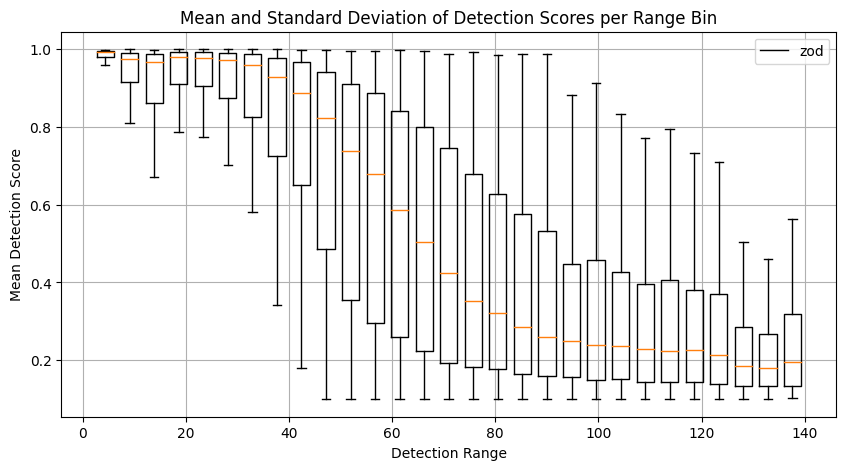

In [7]:
df_det_vehicles = detections_all[detections_all['name'] == 'Vehicle']

#add x and y
df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])

#add range
df_det_vehicles['range'] = np.sqrt(df_det_vehicles['x']**2 + df_det_vehicles['y']**2)

train_datasets = df_det_vehicles['train_dataset'].unique()
eval_datasets = df_det_vehicles['eval_dataset'].unique()

plt.figure(figsize=(10, 5))
plt.title('Detection Score per Range Bin')

for dataset in eval_datasets:
#for dataset in datasets:
    #df = df_det_vehicles[df_det_vehicles['dataset'] == dataset]
    df = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(2, 140, num=30)  # Creates 20 evenly spaced bins

    # Bin the data
    binned_indices = pd.cut(df['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = df.groupby(binned_indices)

    # Calculate mean and standard deviation for each bin
    mean_scores = grouped['score'].mean()
    std_devs = grouped['score'].std()

    # Collect scores for each bin for boxplots
    binned_scores = [group['score'].values for _, group in grouped]

    # Midpoints of bins for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Add boxplots
    for i, bin_midpoint in enumerate(bin_midpoints):
        plt.boxplot(binned_scores[i], positions=[bin_midpoint], widths=np.min(np.diff(bin_midpoints)) * 0.7, manage_ticks=False, showfliers=False)

    # Plotting
    #plt.errorbar(bin_midpoints, mean_scores, yerr=std_devs, fmt='-o', capsize=5)

    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Mean Detection Score')
    #plt.title('Mean and Standard Deviation of Detection Scores per Range Bin for Dataset {}'.format(dataset))
    plt.title('Mean and Standard Deviation of Detection Scores per Range Bin')
    plt.grid(True)

# Display the plot
plt.legend(train_datasets)
plt.show()


In [8]:
mean_scores_zod = mean_scores

In [12]:
diff = mean_scores_zod - mean_scores_avltruck
# Add diff to each score according to the bin they fall into
df_det_vehicles['score_diff'] = df_det_vehicles['range'].apply(lambda x: diff[np.clip(np.digitize(x, bin_edges)-1, 0, len(diff)-1)])
df_det_vehicles['adjusted_score'] = df_det_vehicles['score'] - df_det_vehicles['score_diff']


/tmp/ipykernel_101826/678754838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['score_diff'] = df_det_vehicles['range'].apply(lambda x: diff[np.clip(np.digitize(x, bin_edges)-1, 0, len(diff)-1)])
/tmp/ipykernel_101826/678754838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['adjusted_score'] = df_det_vehicles['score'] - df_det_vehicles['score_diff']


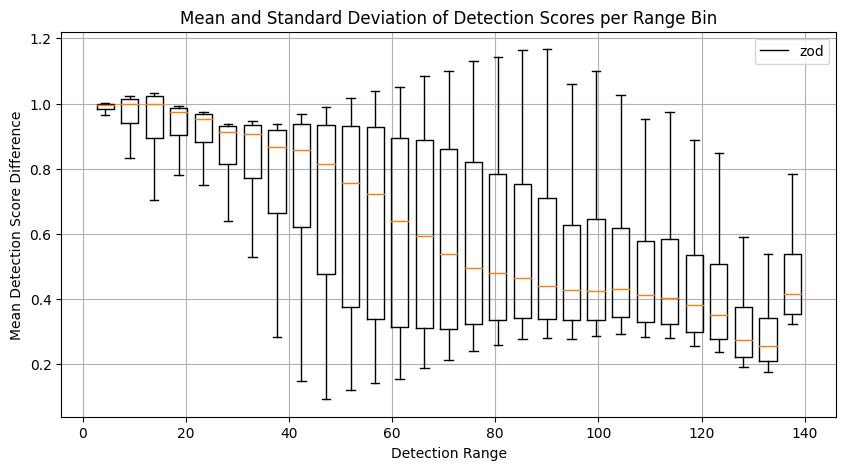

In [13]:
#plot score diff per range bin
plt.figure(figsize=(10, 5))
plt.title('Detection Score Difference per Range Bin')

for dataset in eval_datasets:
#for dataset in datasets:
    #df = df_det_vehicles[df_det_vehicles['dataset'] == dataset]
    df = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(2, 140, num=30)  # Creates 20 evenly spaced bins

    # Bin the data
    binned_indices = pd.cut(df['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = df.groupby(binned_indices)

    # Calculate mean and standard deviation for each bin
    mean_scores = grouped['adjusted_score'].mean()
    std_devs = grouped['adjusted_score'].std()

    # Collect scores for each bin for boxplots
    binned_scores = [group['adjusted_score'].values for _, group in grouped]

    # Midpoints of bins for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Add boxplots
    for i, bin_midpoint in enumerate(bin_midpoints):
        plt.boxplot(binned_scores[i], positions=[bin_midpoint], widths=np.min(np.diff(bin_midpoints)) * 0.7, manage_ticks=False, showfliers=False)

    # Plotting
    #plt.errorbar(bin_midpoints, mean_scores, yerr=std_devs, fmt='-o', capsize=5)

    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Mean Detection Score Difference')
    #plt.title('Mean and Standard Deviation of Detection Scores per Range Bin for Dataset {}'.format(dataset))
    plt.title('Mean and Standard Deviation of Detection Scores per Range Bin')
    plt.grid(True)

# Display the plot
plt.legend(train_datasets)
plt.show()


### Plot range dist of gt labels

In [ ]:
# add range to gt labels
gt_labels['x'] = gt_labels['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels['y'] = gt_labels['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels['range'] = np.sqrt(gt_labels['x']**2 + gt_labels['y']**2)
# add range to detections
df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
df_det_vehicles['range'] = np.sqrt(df_det_vehicles['x']**2 + df_det_vehicles['y']**2)

datasets = gt_labels['dataset'].unique()
for dataset in datasets:
    gt_labels_dataset = gt_labels[gt_labels['dataset'] == dataset]
    df_det_vehicles_dataset = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    max_range = 140
    gt_labels_dataset = gt_labels_dataset[gt_labels_dataset['range'] < max_range]
    df_det_vehicles_dataset = df_det_vehicles_dataset[df_det_vehicles_dataset['range'] < max_range]
    
    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(0, 140, num=140)  # Create one bin for each meter of range

    # Bin the data
    binned_indices = pd.cut(gt_labels_dataset['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = gt_labels_dataset.groupby(binned_indices)


    # Plot histogram
    #plt.hist(gt_labels_dataset['range'], bins=bin_edges, density=True, histtype='bar', label='Ground Truth', alpha=0.5)
    plt.hist(df_det_vehicles_dataset['range'], bins=bin_edges, density=True, histtype='bar', label='Detections', alpha=0.5, color='orange')
    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Number of Detections')
    plt.title('Number of Detections per Range Bin for Dataset {}'.format(dataset))
    plt.grid(True)

    # Display the plot
    plt.show()



### Add detection true_labels to detections and detection results for gt labels

In [16]:
#reduce gt labels to frames that are in the detections
gt_labels_all = gt_labels_all[gt_labels_all['frame_id'].isin(detections_all['frame_id'].unique())]
# XXX: remove frames that have no gt labels from gts and dts

#add x, y, range, angle
detections_all['x'] = detections_all['boxes_lidar'].apply(lambda x: x[0])
detections_all['y'] = detections_all['boxes_lidar'].apply(lambda x: x[1])
detections_all['range'] = np.sqrt(detections_all['x']**2 + detections_all['y']**2)
detections_all['angle'] = np.arctan2(detections_all['y'], detections_all['x'])*180/np.pi

gt_labels_all['x'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels_all['y'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels_all['range'] = np.sqrt(gt_labels_all['x']**2 + gt_labels_all['y']**2)
gt_labels_all['angle'] = np.arctan2(gt_labels_all['y'], gt_labels_all['x'])*180/np.pi

def plot_alignment_infos(df_det, df_gt):
    eval_datasets = df_det['eval_dataset'].unique()

    for eval_dataset in eval_datasets:
        #print max range and minmax angle for each dataset
        print(eval_dataset, "detections")
        print("max range: ", df_det[df_det['eval_dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].max())
        print("")

        print(eval_dataset, "gt labels")
        print("max range: ", df_gt[df_gt['dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].max())
        print("")

        #plot angle histo for detections and gt labels (same figure) for the vehicle class
        fig, axs = plt.subplots(1,2, figsize=(14, 7))

        #plot detections
        df_det_vehicles = df_det[(df_det['eval_dataset'] == eval_dataset)]
        df_det_vehicles = df_det_vehicles[df_det_vehicles['range'] < 140]
        sns.histplot(data=df_det_vehicles, x='angle', hue='eval_dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[0])
        axs[0].set_xlabel("Angle")
        axs[0].set_ylabel("Count")
        axs[0].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        #plot gt labels
        df_gt_vehicles = df_gt[(df_gt['dataset'] == eval_dataset)]
        df_gt_vehicles = df_gt_vehicles[df_gt_vehicles['range'] < 140]
        sns.histplot(data=df_gt_vehicles, x='angle', hue='dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[1])
        axs[1].set_xlabel("Angle")
        axs[1].set_ylabel("Count")
        axs[1].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        plt.tight_layout()

        plt.show()

#reduce to vehicle class
detections_vehicles = detections_all[detections_all['name'] == 'Vehicle']
gt_labels_vehicles = gt_labels_all[gt_labels_all['names'] == 'Vehicle']

#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)

#align datasets
min_angle = -60
max_angle = 60
max_range = 140

detections_vehicles = detections_vehicles[(detections_vehicles['angle'] >= min_angle) & (detections_vehicles['angle'] <= max_angle)]
detections_vehicles = detections_vehicles[detections_vehicles['range'] < max_range]

gt_labels_vehicles = gt_labels_vehicles[(gt_labels_vehicles['angle'] >= min_angle) & (gt_labels_vehicles['angle'] <= max_angle)]
gt_labels_vehicles = gt_labels_vehicles[gt_labels_vehicles['range'] < max_range]
detections_vehicles.reset_index(drop=True, inplace=True)
gt_labels_vehicles.reset_index(drop=True, inplace=True)
#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)

#calc ious
detections_vehicles, gt_labels_vehicles = calc_ious(detections_vehicles, gt_labels_vehicles)





  0%|          | 0/7892 [00:00<?, ?it/s]/home/cgriesbacher/thesis/3DTrans/pcdet/ops/iou3d_nms/iou3d_nms_utils.py:41: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  ans_iou = torch.cuda.FloatTensor(torch.Size((boxes_a.shape[0], boxes_b.shape[0]))).zero_()
  9%|▉         | 711/7892 [00:06<01:03, 113.35it/s]

Frame sequences/CityStreet_dgt_2021-11-04-12-50-12_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/CityStreet_dgt_2021-11-04-12-50-12_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/CityStreet_dgt_2021-11-04-12-50-12_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 41%|████      | 3208/7892 [00:29<00:41, 111.64it/s]

Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/CityThoroughfare_dgt_2021-11-11-11-04-09_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 45%|████▍     | 3522/7892 [00:32<00:36, 121.25it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-47-34_0_s0/dataset/logical_frame_000003.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-03-14-10-57_0_s0/dataset/l

 45%|████▍     | 3549/7892 [00:32<00:34, 126.97it/s]

Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-19-13-40-24_0_s0/dataset/l

 46%|████▌     | 3604/7892 [00:32<00:32, 132.17it/s]

Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000026.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000023.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-31-09-49-30_0_s0/dataset/l

 47%|████▋     | 3710/7892 [00:33<00:33, 124.05it/s]

Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/MinorRoad_dgt_2021-08-30-14-12-19_0_s0/dataset/l

 50%|████▉     | 3930/7892 [00:35<00:44, 88.30it/s] 

Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-02-15-51-11_0_s0/dataset/logical_fr

 55%|█████▍    | 4319/7892 [00:39<00:29, 121.09it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-48-53_0_s0/dataset/logical_fr

 61%|██████    | 4822/7892 [00:43<00:24, 124.19it/s]

Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-09-27-31_0_s0/dataset/logical_fr

 62%|██████▏   | 4861/7892 [00:44<00:24, 123.71it/s]

Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-12-33-49_0_s0/dataset/logical_frame_000015.json has no gts or no detections


 65%|██████▌   | 5145/7892 [00:46<00:22, 120.78it/s]

Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-49-55_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 67%|██████▋   | 5284/7892 [00:47<00:22, 115.36it/s]

Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-10-40-27_0_s0/dataset/logical_frame_000006.json has no gts or no detections


 69%|██████▉   | 5483/7892 [00:49<00:20, 119.30it/s]

Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-08-19-15-15-50_0_s0/dataset/logical_frame_000009.json has no gts or no detections


 70%|██████▉   | 5521/7892 [00:49<00:19, 120.91it/s]

Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-16-08-35-34_0_s0/dataset/logical_fr

 71%|███████   | 5573/7892 [00:50<00:18, 123.08it/s]

Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-03-10-05-53_0_s0/dataset/logical_frame_000003.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-14-14-33-02_0_s0/dataset/logical_frame_000001.json has no gts or no detections


 74%|███████▍  | 5846/7892 [00:52<00:17, 119.90it/s]

Frame sequences/Motorway_dgt_2021-09-15-16-12-29_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/Motorway_dgt_2021-09-15-16-12-29_0_s0/dataset/logical_frame_000019.json has no gts or no detections


 77%|███████▋  | 6100/7892 [00:54<00:14, 124.61it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-11-25-34_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/PrimaryH

 78%|███████▊  | 6190/7892 [00:55<00:13, 123.57it/s]

Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-11-25-09-36-46_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/PrimaryH

 79%|███████▉  | 6255/7892 [00:55<00:13, 125.08it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-09-34-51_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryH

 80%|███████▉  | 6294/7892 [00:56<00:13, 121.98it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000015.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-30-10-12-40_0_s0/dataset/logical_frame_000014.json has no gts or no detections


 85%|████████▍ | 6682/7892 [00:59<00:10, 114.08it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-23-09-52-00_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-23-09-52-00_0_s0/dataset/logical_frame_000002.json has no gts or no detections


 86%|████████▌ | 6795/7892 [01:00<00:09, 118.83it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-13-11-15-16_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 87%|████████▋ | 6858/7892 [01:01<00:08, 117.90it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000010.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000011.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000009.json has no gts or no detections
Frame sequences/PrimaryHighway_dgt_2021-07-21-11-18-59_0_s0/dataset/logical_frame_000006.json has no gts or no detections
Frame sequences/PrimaryH

 91%|█████████ | 7154/7892 [01:03<00:06, 117.79it/s]

Frame sequences/PrimaryHighway_dgt_2021-07-30-09-58-29_0_s0/dataset/logical_frame_000020.json has no gts or no detections


 92%|█████████▏| 7251/7892 [01:04<00:05, 118.45it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000020.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000019.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-21-11-45-51_0_s0/dataset/logical_frame_000015.json has no gts or no detections


 93%|█████████▎| 7374/7892 [01:05<00:04, 120.64it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000001.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-07-08-12-25-30_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame se

 95%|█████████▍| 7483/7892 [01:06<00:03, 116.98it/s]

Frame sequences/SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0/dataset/logical_frame_000002.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0/dataset/logical_frame_000004.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-11-05-10-32-59_0_s0/dataset/logical_frame_000003.json has no gts or no detections


 97%|█████████▋| 7640/7892 [01:08<00:02, 114.67it/s]

Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-11-04_0_s0/dataset/logical_frame_000011.json has no gts or no detections


 98%|█████████▊| 7712/7892 [01:08<00:01, 115.77it/s]

Frame sequences/SecondaryHighway_dgt_2021-07-23-13-02-47_0_s0/dataset/logical_frame_000020.json has no gts or no detections


100%|██████████| 7892/7892 [01:10<00:00, 112.20it/s]


Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000008.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000013.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000012.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000007.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000016.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000018.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000005.json has no gts or no detections
Frame sequences/SecondaryHighway_dgt_2021-08-19-14-30-19_0_s0/dataset/logical_frame_000017.json has no gts or no detections
Frame se

In [ ]:
plot_confusion_matrix(detections_vehicles, gt_labels_vehicles, 0.5, epochs="50", pseudo_labels_folder_path=None, show_plot=True, do_print=False)

### Analyze IOU threshold

In [ ]:

iou_thresholds = np.arange(0.05, 1, 0.05)

vehicles_vehicle = []
vehicles_background = []
background_vehicle = []

for iou_threshold in iou_thresholds:
    detections_vehicles[f'detected_{iou_threshold}'] = detections_vehicles['iou'] >= iou_threshold
    gt_labels_vehicles[f'detected_{iou_threshold}'] = gt_labels_vehicles['iou'] >= iou_threshold

    
    vehicles_vehicle.append(len(detections_vehicles[(detections_vehicles[f'detected_{iou_threshold}'] == True) & (detections_vehicles['true_label'] == 'Vehicle')]))
    vehicles_background.append(len(detections_vehicles[(detections_vehicles[f'detected_{iou_threshold}'] == False)]))
    background_vehicle.append(len(gt_labels_vehicles[(gt_labels_vehicles[f'detected_{iou_threshold}'] == False) & (gt_labels_vehicles['names'] == 'Vehicle')]))

#convert to percentage of detections
vehicles_vehicle = np.array(vehicles_vehicle)/len(detections_vehicles)
vehicles_background = np.array(vehicles_background)/len(detections_vehicles)
background_vehicle = np.array(background_vehicle)/len(gt_labels_vehicles)

plt.figure(figsize=(10, 5))
plt.title('Number of detections per iou threshold')
plt.plot(iou_thresholds, vehicles_vehicle, label='detected as vehicle, true label vehicle')
plt.plot(iou_thresholds, vehicles_background, label='detected as vehicle, true label background')
plt.plot(iou_thresholds, background_vehicle, label='detected as background, true label vehicle')
plt.legend()
plt.xlabel('iou threshold')
plt.ylabel('Number of detections')
plt.grid(True)
plt.show()


In [17]:
detections_vehicles['score_diff'] = detections_vehicles['range'].apply(lambda x: diff[np.clip(np.digitize(x, bin_edges)-1, 0, len(diff)-1)])


In [18]:
detections_vehicles['adjusted_score'] = detections_vehicles['score'] + detections_vehicles['score_diff']

### Analyze score threshold

delta_score is -0.0 k is -0.0
most true labels for iou 0.7 is 0.55 with 58684  true labels and 9893 false labels
false vehicles 3966
undetected vehicles 5927


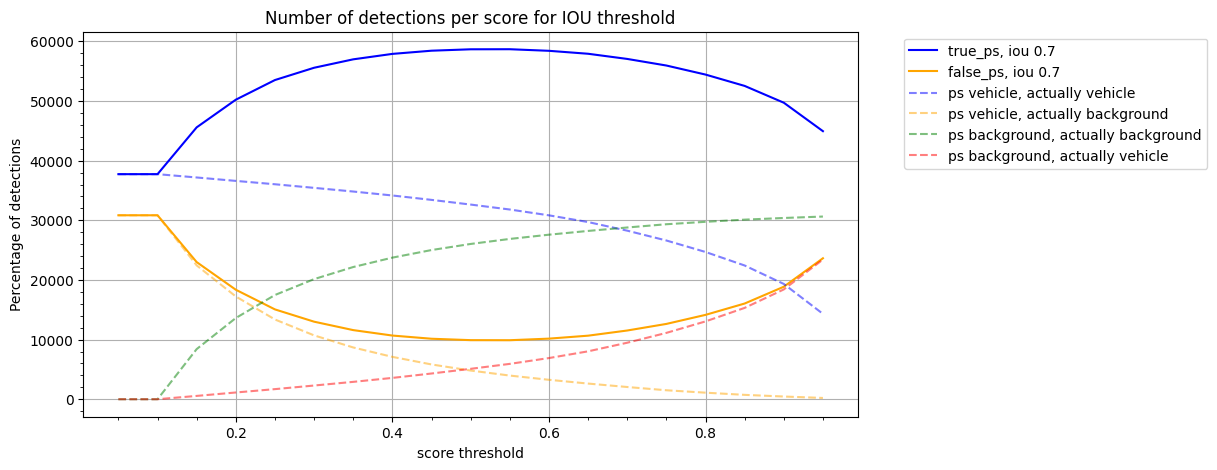

In [32]:
score_thresholds = np.arange(0.05, 1, 0.05)
#iou_thresholds = [0.3, 0.5, 0.7]
iou_thresholds = [0.7]
line_types = ['-', '--', ':']
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 5))
plt.title('Number of detections per score for IOU threshold')

max_dist = 130

delta_scores = np.arange(-1, 1, 0.1)
delta_scores = [-0.0]

for delta_score in delta_scores:
    k = delta_score/max_dist
    print("delta_score is", delta_score, "k is", k)
    for iou_threshold in iou_thresholds:
        true_tp = []
        false_tp = []
        true_fn = []
        false_fn = []

        for score_threshold in score_thresholds:
            
            #range dependent score threshold
            range_dep_score_threshold = score_threshold + k*detections_vehicles['range']
            detections_vehicles[f'ps_vehicle_{score_threshold}'] = detections_vehicles['score'] >= range_dep_score_threshold

            #static score threshold
            #detections_vehicles[f'ps_vehicle_{score_threshold}'] = detections_vehicles['score'] >= score_threshold
            
            #reduce to max dist
            detections_vehicles_max_dist = detections_vehicles[detections_vehicles['range'] < max_dist]


            true_tp.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == True) & (detections_vehicles[f'detected_{iou_threshold}'] == True)]))
            false_tp.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == True) & (detections_vehicles[f'detected_{iou_threshold}'] == False)]))
            true_fn.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == False) & (detections_vehicles[f'detected_{iou_threshold}'] == False)]))
            false_fn.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == False) & (detections_vehicles[f'detected_{iou_threshold}'] == True)]))


        true_tp = np.array(true_tp)
        false_tp = np.array(false_tp)
        true_fn = np.array(true_fn)
        false_fn = np.array(false_fn)
        
        # convert to percentage of detections
        #true_tp = np.array(true_tp)/len(detections_vehicles)
        #false_tp = np.array(false_tp)/len(detections_vehicles)
        #true_fn = np.array(true_fn)/len(detections_vehicles)
        #false_fn = np.array(false_fn)/len(detections_vehicles)

        # XXX: Chance percentage to percentage of actual true labels 

        true_labels = true_tp + true_fn
        false_labels = false_tp + false_fn

        plt.plot(score_thresholds, true_labels, label=f'true_ps, iou {iou_threshold}', linestyle="-", color=colors[0])
        plt.plot(score_thresholds, false_labels, label=f'false_ps, iou {iou_threshold}', linestyle="-", color=colors[1])
        plt.plot(score_thresholds, true_tp, label='ps vehicle, actually vehicle', linestyle="--", color=colors[0], alpha=0.5)
        plt.plot(score_thresholds, false_tp, label='ps vehicle, actually background', linestyle="--", color=colors[1], alpha=0.5)
        plt.plot(score_thresholds, true_fn, label='ps background, actually background', linestyle="--", color=colors[2], alpha=0.5)
        plt.plot(score_thresholds, false_fn, label='ps background, actually vehicle', linestyle="--", color=colors[3], alpha=0.5)

        best_score_index = np.argmax(true_labels)
        best_score_threshold = score_thresholds[best_score_index]
        print("most true labels for iou", iou_threshold, "is", np.round(best_score_threshold, 2), "with", np.round(true_labels[best_score_index], 3) ," true labels and", np.round(false_labels[best_score_index], 3), "false labels")
        print("false vehicles", np.round(false_tp[best_score_index], 3))
        print("undetected vehicles", np.round(false_fn[best_score_index], 3))

#plot legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('score threshold')
plt.ylabel('Percentage of detections')
plt.minorticks_on()
plt.grid(True)
plt.show()


IndexError: list index out of range

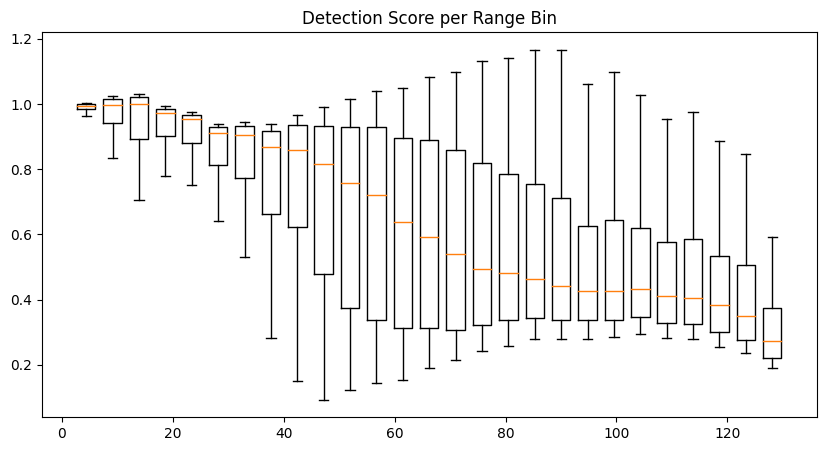

In [26]:

df_det_vehicle = detections_vehicles
train_datasets = df_det_vehicles['train_dataset'].unique()
eval_datasets = df_det_vehicles['eval_dataset'].unique()

plt.figure(figsize=(10, 5))
plt.title('Detection Score per Range Bin')

for dataset in eval_datasets:
#for dataset in datasets:
    #df = df_det_vehicles[df_det_vehicles['dataset'] == dataset]
    df = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(2, 140, num=30)  # Creates 20 evenly spaced bins

    # Bin the data
    binned_indices = pd.cut(df['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = df.groupby(binned_indices)

    # Calculate mean and standard deviation for each bin
    mean_scores = grouped['adjusted_score'].mean()
    std_devs = grouped['adjusted_score'].std()

    # Collect scores for each bin for boxplots
    binned_scores = [group['adjusted_score'].values for _, group in grouped]

    # Midpoints of bins for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Add boxplots
    for i, bin_midpoint in enumerate(bin_midpoints):
        plt.boxplot(binned_scores[i], positions=[bin_midpoint], widths=np.min(np.diff(bin_midpoints)) * 0.7, manage_ticks=False, showfliers=False)

    # Plotting
    #plt.errorbar(bin_midpoints, mean_scores, yerr=std_devs, fmt='-o', capsize=5)

    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Mean Detection Score')
    #plt.title('Mean and Standard Deviation of Detection Scores per Range Bin for Dataset {}'.format(dataset))
    plt.title('Mean and Standard Deviation of Detection Scores per Range Bin')
    plt.grid(True)

# Display the plot
plt.legend(train_datasets)
plt.show()
